In [1]:
%%capture
!pip install ai-edge-torch==0.4.0
!pip install gcpds-cv-pykit

In [2]:
import wandb
import ai_edge_torch
import torch
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from ai_edge_litert.interpreter import Interpreter
from gcpds_cv_pykit.datasets import FeetMamitas
from ai_edge_litert.interpreter import Interpreter
from gcpds_cv_pykit.baseline.dataloaders import Segmentation_DataLoader
from gcpds_cv_pykit.visuals import random_sample_visualization
from gcpds_cv_pykit.baseline.models import UNet

/usr/local/lib/python3.12/dist-packages/torch/distributed/distributed_c10d.py:351: UserWarning: Device capability of jax unspecified, assuming `cpu` and `cuda`. Please specify it via the `devices` argument of `register_backend`.
  warnings.warn(


In [3]:
# Set a seed
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
FeetMamitas()

100%|██████████| 35.4M/35.4M [00:01<00:00, 23.7MB/s]

Extracting files...


Path to downloaded dataset files: /root/.cache/kagglehub/datasets/lucasiturriago/feet-mamitas/versions/3
Dataset copied to: /content/datasets/feet-mamitas
Original folder '/root/.cache/kagglehub/datasets/lucasiturriago/feet-mamitas/versions/3' deleted.


'/content/datasets/feet-mamitas'

In [ ]:
config = {"Dir of dataset": "./datasets/feet-mamitas", "Batch size": 1, "Image size": (256,256), "Input size": (3,256,256),
          "Number of classes": 1, "Single class train": None, "Single class test": None, "Single class valid": None, "Images folder": "images",
          "Data augmentation": False, "Device": "cuda:0", "AMixPre": True, "Backbone": "resnet34","Pretrained": True, "Activation function": "sigmoid",
          "Save results": True, "Wandb monitoring": ["WandB_API_Key"]}

In [50]:
train_dataset = Segmentation_DataLoader(config["Dir of dataset"], config["Batch size"], config["Image size"], config["Number of classes"],
                                        "Train", config["Single class train"], config["Data augmentation"], config["Images folder"],pin_memory=False)

Searching for images in: datasets/feet-mamitas/Train/images
Supported formats: *.png, *.jpg, *.jpeg
Number of image files found: 248


Organizing masks: 100%|██████████| 248/248 [00:00<00:00, 125656.85it/s]


In [51]:
valid_dataset = Segmentation_DataLoader(config["Dir of dataset"], 1, config["Image size"], config["Number of classes"],
                                        "Valid", config["Single class valid"], config["Data augmentation"], config["Images folder"],pin_memory=False)

Searching for images in: datasets/feet-mamitas/Valid/images
Supported formats: *.png, *.jpg, *.jpeg
Number of image files found: 71


Organizing masks: 100%|██████████| 71/71 [00:00<00:00, 47823.28it/s]


In [52]:
test_dataset = Segmentation_DataLoader(config["Dir of dataset"], config["Batch size"], config["Image size"], config["Number of classes"],
                                        "Test", config["Single class test"], config["Data augmentation"], config["Images folder"],pin_memory=False)

Searching for images in: datasets/feet-mamitas/Test/images
Supported formats: *.png, *.jpg, *.jpeg
Number of image files found: 35


Organizing masks: 100%|██████████| 35/35 [00:00<00:00, 71401.09it/s]


Images: torch.Size([1, 3, 256, 256]), Masks: torch.Size([1, 1, 256, 256])


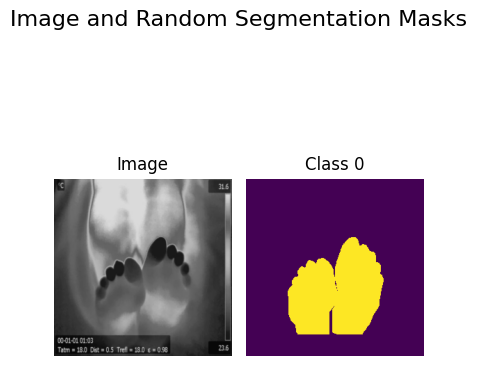

In [53]:
random_sample_visualization(dataset=train_dataset, num_classes=config["Number of classes"],
                            single_class=config['Single class train'],type='baseline')

In [ ]:
wandb.login(key=config["Wandb monitoring"][0])
run = wandb.init()
artifact = run.use_artifact('gcpds/MasterTests/best_model:v53', type='model')
artifact_dir = artifact.download()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: liturriago (gcpds) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact 'best_model:v53', 93.60MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:05.1 (18.5MB/s)


In [12]:
model = UNet(in_channels=config["Input size"][0],out_channels=config["Number of classes"], final_activation=config["Activation function"])
state_dict = torch.load('./artifacts/best_model:v53/best_model.pt', weights_only=True,map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()
model_nhwc = ai_edge_torch.to_channel_last_io(model, args=[0])

In [13]:
def representative_dataset():
    for data, _ in valid_dataset:
        arr = data.numpy().astype(np.float32)
        arr = np.transpose(arr, (0, 2, 3, 1))
        yield [arr]

In [14]:
tfl_converter_flags = {
    'optimizations': [tf.lite.Optimize.DEFAULT],
    'representative_dataset': representative_dataset,
    'target_spec': {
        'supported_ops': [tf.lite.OpsSet.TFLITE_BUILTINS],
        'supported_types': [tf.float16]
    }
}

In [15]:
C = config["Input size"][0]
sample_input = (torch.randn(1, 256, 256, C),)
edge_model = ai_edge_torch.convert(
    model_nhwc,
    sample_input,
    _ai_edge_converter_flags=tfl_converter_flags)

edge_model.export("model_fp16.tflite")

In [16]:
interpreter = Interpreter(model_path="./model_fp16.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("=== INPUTS ===")
for i, d in enumerate(input_details):
    print(f"Input {i}: name={d['name']} shape={d['shape']} dtype={d['dtype']}")

print("\n=== OUTPUTS ===")
for i, d in enumerate(output_details):
    print(f"Output {i}: name={d['name']} shape={d['shape']} dtype={d['dtype']}")

=== INPUTS ===
Input 0: name=serving_default_args_0:0 shape=[  1 256 256   3] dtype=<class 'numpy.float32'>

=== OUTPUTS ===
Output 0: name=StatefulPartitionedCall:0 shape=[  1   1 256 256] dtype=<class 'numpy.float32'>


In [43]:
sample = 26
for i, (image, mask) in enumerate(test_dataset):
    if i == sample:
      break
print(image.shape, mask.shape)
prediction = model(image)
image = image.numpy().transpose(0,2,3,1)
mask = mask.numpy().transpose(0,2,3,1)

torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256])


In [44]:
interpreter.set_tensor(input_details[0]['index'], image)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

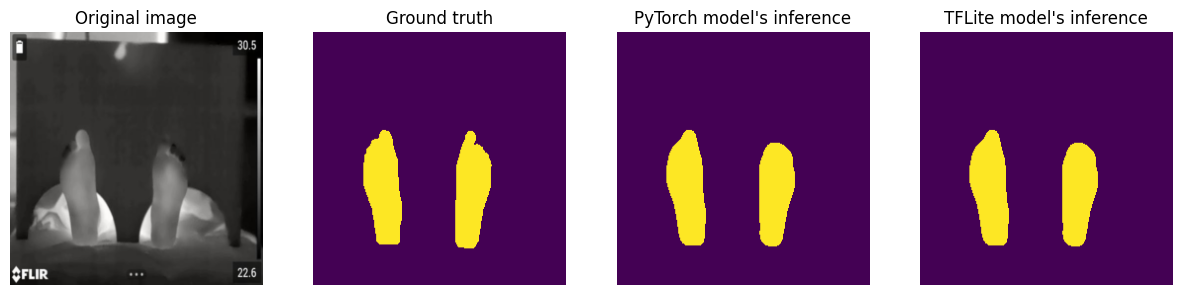

In [48]:
fig, axs = plt.subplots(1,4,figsize=(15,15))
axs[0].imshow(image[0])
axs[0].set_title('Original image')
axs[0].axis('off')
axs[1].imshow(mask[0][:,:,0])
axs[1].set_title('Ground truth')
axs[1].axis('off')
axs[2].imshow(np.where(prediction[0][0,:,:]>0.5,1,0))
axs[2].set_title('PyTorch model\'s inference')
axs[2].axis('off')
axs[3].imshow(np.where(output_data[0][0,:,:]>0.5,1,0))
axs[3].set_title("TFLite model\'s inference")
axs[3].axis('off')
plt.savefig('results.png')
plt.show()